Usikkerheden fra støjen på sensoren bestemmes ved standardafvigelsen på målingerne fra nulmålingen.

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Filstier
nulmåling_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 13 - Harmonisk oscillator\data\nulmåling_lab12.csv"
frimåling_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 13 - Harmonisk oscillator\data\frimåling_lab12.csv"
luftmodstandsmåling_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 13 - Harmonisk oscillator\data\luftmodstandmåling_lab12.csv"
skinnemåling_loc = r"C:\Users\marcu\OneDrive\Documents\GitHub\MekRelLab\Lab 13 - Harmonisk oscillator\data\skinnemåling_lab12.csv"

# Indlæs data
# [s] og [V]
nulmåling = np.genfromtxt(nulmåling_loc, delimiter=",", skip_header=1)
nulmåling_t_arr = nulmåling[:, 0]
nulmåling_v_arr = nulmåling[:, 1]

frimåling = np.genfromtxt(frimåling_loc, delimiter=",", skip_header=1)
frimåling_t_arr = frimåling[:, 0]
frimåling_v_arr = frimåling[:, 1]

luftmodstandsmåling = np.genfromtxt(luftmodstandsmåling_loc, delimiter=",", skip_header=1)
luftmodstandsmåling_t_arr = luftmodstandsmåling[:, 0]
luftmodstandsmåling_v_arr = luftmodstandsmåling[:, 1]

skinnemåling = np.genfromtxt(skinnemåling_loc, delimiter=",", skip_header=1)
skinnemåling_t_arr = skinnemåling[:, 0]
skinnemåling_v_arr = skinnemåling[:, 1]

# Usikkerheden fra signalstøj er standardafvigelsen på vores nulmåling afrundet til første ciffer
# [V]
usikkerhed_signalstøj = round(np.std(nulmåling_v_arr), 3)
usikkerhed_signalstøj

# Usikkerheden på tiden er 
# [s]
usikkerhed_t = 0.000125

Vi plotter vores data (eksklusive nulmålingen) for at se om der er punkter vi ikke skal tage med i fittet

Frimåling


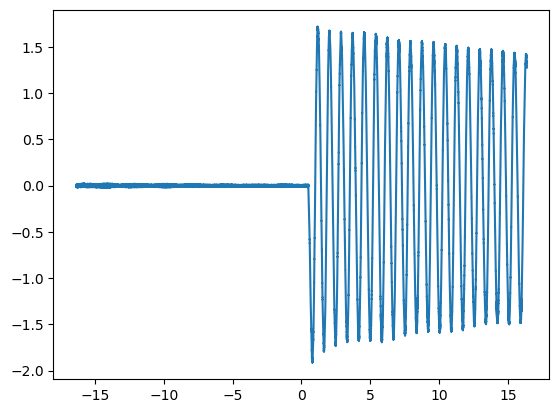

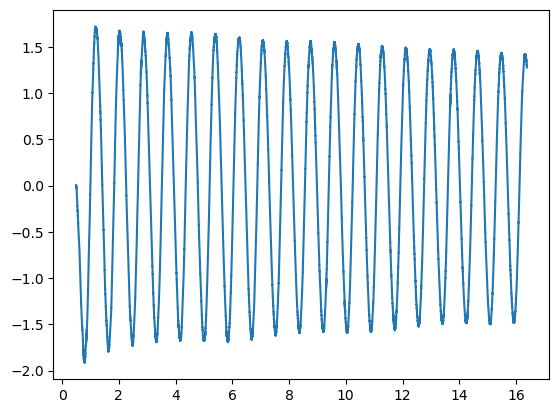

Skinnemåling


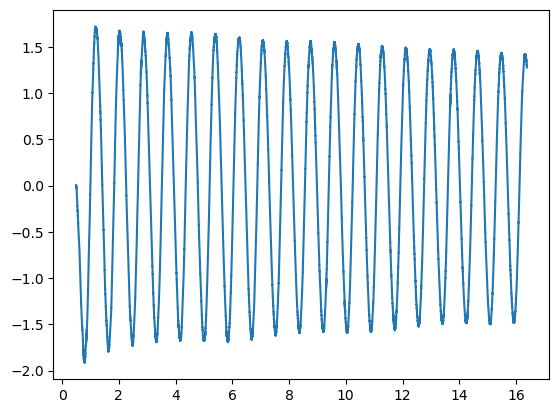

Luftmodstandsmåling


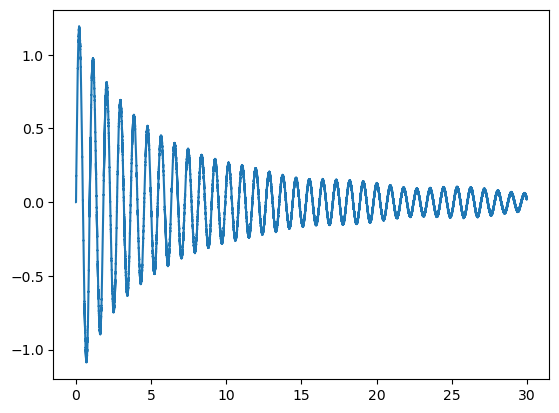

In [119]:
# Plot af data
print("Frimåling")
plt.figure(1)
plt.figsize = (10, 10)
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Frimaling")
plt.show()

# Slet de første 135k punkter fra frimåling
frimåling_t_arr = frimåling_t_arr[135000:]
frimåling_v_arr = frimåling_v_arr[135000:]

plt.figure()
plt.figsize = (10, 10)
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Frimaling")
plt.show()

print("Skinnemåling")
plt.figure()
plt.figsize = (10, 10)
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Frimaling")
plt.show()

print("Luftmodstandsmåling")
plt.figure()
plt.figsize = (10, 10)
plt.plot(luftmodstandsmåling_t_arr, luftmodstandsmåling_v_arr, label="Frimaling")
plt.show()



Vi fitter diverse modeller til datasættet for den udæmpede oscillator.

In [120]:
import sympy as sp
from scipy.optimize import curve_fit

def ingen_dæmp_func(t, A, omega, phi):
    return A*np.sin(omega*t + phi)

def lin_dæmp_func(t, A_0, D, omega, phi):
    return (-1.8 - D*t)*np.sin(omega*t + phi)

def exp_dæmp_func(t, A_0, D, omega, phi):
    return (A_0*np.exp(-D*t))*np.sin(omega*t + phi)



Ingen dæmpning

In [121]:
# Lav fittet
ingen_dæmp_startgæt = [1.5, 7.8, 5.12885193]
ingen_dæmp_param, ingen_dæmp_cov = curve_fit(ingen_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True, p0=ingen_dæmp_startgæt)

# Tilføj propageret usikkerhed fra tiden til positionen
A, omega, phi = ingen_dæmp_param

ingen_dæmp_sigma = np.sqrt(np.diagonal(ingen_dæmp_cov))
ingen_dæmp_sigma_prop_u = [(-A*omega*np.sin(omega*t - phi))*usikkerhed_t + usikkerhed_signalstøj for t in frimåling_t_arr]

# Gentag fittet med den propagerede usikkerhed
ingen_dæmp_param, ingen_dæmp_cov = curve_fit(ingen_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=ingen_dæmp_sigma_prop_u, absolute_sigma=True, p0=ingen_dæmp_startgæt)

# Udregn reduceret chi^2
ingen_dæmp_chi_red = np.sum(((frimåling_v_arr - ingen_dæmp_func(frimåling_t_arr, *ingen_dæmp_param))/ingen_dæmp_sigma_prop_u)**2)/(len(frimåling_t_arr) - len(ingen_dæmp_param))

print("Parametre")
print(ingen_dæmp_param)
print("Chi^2 red")
print(ingen_dæmp_chi_red)

Parametre
[-1.59904121  7.47642978  8.24373416]
Chi^2 red
460.42738845118447


Linær dæmpning

In [122]:
# Lav fittet
lin_dæmp_startgæt = [-1.8, -0.09077228, 9.9168077, 2.63312925]

lin_dæmp_param, lin_dæmp_cov = curve_fit(lin_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True ,p0=lin_dæmp_startgæt, maxfev=100000)

# Tilføj propageret usikkerhed fra tiden til positionen
A_0, D, omega, phi = lin_dæmp_param

lin_dæmp_sigma = np.sqrt(np.diagonal(lin_dæmp_cov))
lin_dæmp_sigma_prop_u = [(-D - (A_0 - D*t)*omega*np.sin(omega*t - phi))*usikkerhed_t + usikkerhed_signalstøj for t in frimåling_t_arr]

# Gentag fittet med den propagerede usikkerhed
lin_dæmp_param, lin_dæmp_cov = curve_fit(lin_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=lin_dæmp_sigma_prop_u, absolute_sigma=True, p0=lin_dæmp_startgæt, maxfev=100000)

# Udregn reduceret chi^2
lin_dæmp_chi_red = np.sum(((frimåling_v_arr - lin_dæmp_func(frimåling_t_arr, *lin_dæmp_param))/lin_dæmp_sigma_prop_u)**2)/(len(frimåling_t_arr) - len(lin_dæmp_param))

print("Parametre")
print(lin_dæmp_param)
print("Chi^2 red")
print(lin_dæmp_chi_red)

Parametre
[-1.8        -0.17244176  9.85955972  5.1966462 ]
Chi^2 red
63841.5928718082


Eksponentiel dæmpning

In [123]:
# Lav fittet
exp_dæmp_startgæt = [-1.5, 1, 7.48253038, 1]
exp_dæmp_param, exp_dæmp_cov = curve_fit(exp_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=np.ones(len(frimåling_t_arr))*usikkerhed_signalstøj, absolute_sigma=True, p0=exp_dæmp_startgæt)

# Tilføj propageret usikkerhed fra tiden til positionen
A_0, D, omega, phi = exp_dæmp_param

exp_dæmp_sigma = np.sqrt(np.diagonal(exp_dæmp_cov))
exp_dæmp_sigma_prop_u = [(-D*t*A_0*np.exp(-D*t) - A_0*np.exp(-D*t)*np.sin(omega*t - phi))*usikkerhed_t + usikkerhed_signalstøj for t in frimåling_t_arr]

# Gentag fittet med den propagerede usikkerhed
exp_dæmp_param, exp_dæmp_cov = curve_fit(exp_dæmp_func, frimåling_t_arr, frimåling_v_arr, sigma=exp_dæmp_sigma_prop_u, absolute_sigma=True, p0=exp_dæmp_startgæt)

# Udregn reduceret chi^2
exp_dæmp_chi_red = np.sum(((frimåling_v_arr - exp_dæmp_func(frimåling_t_arr, *exp_dæmp_param))/exp_dæmp_sigma_prop_u)**2)/(len(frimåling_t_arr) - len(exp_dæmp_param))

print("Parametre")
print(exp_dæmp_param)
print("Chi^2 red")
print(exp_dæmp_chi_red)


Parametre
[-1.74819444  0.01223595  7.47449984  1.98486737]
Chi^2 red
282.4050337287442


Vi plotter fitsne sammen med vores data for den udæmpede oscillator

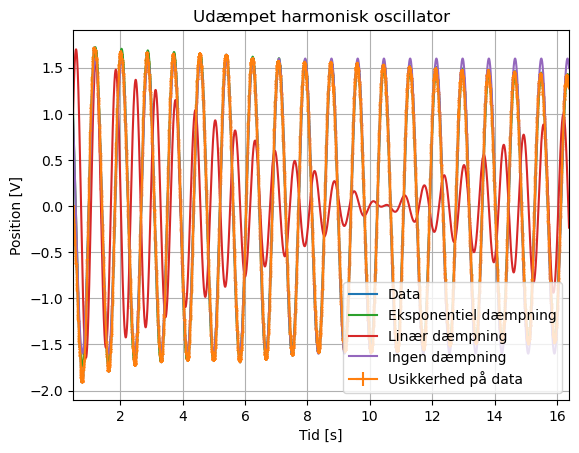

In [126]:

plt.figure(1)
plt.grid()
plt.xlabel("Tid [s]")
plt.ylabel("Position [V]")
plt.title("Udæmpet harmonisk oscillator")

# Plot af data
plt.plot(frimåling_t_arr, frimåling_v_arr, label="Data")
plt.errorbar(frimåling_t_arr, frimåling_v_arr, xerr=usikkerhed_t, yerr=usikkerhed_signalstøj, label="Usikkerhed på data")

# Plot af fits
plt.plot(frimåling_t_arr, exp_dæmp_func(frimåling_t_arr, *exp_dæmp_param), label="Eksponentiel dæmpning")
plt.plot(frimåling_t_arr, lin_dæmp_func(frimåling_t_arr, *lin_dæmp_param), label="Linær dæmpning")
plt.plot(frimåling_t_arr, ingen_dæmp_func(frimåling_t_arr, *ingen_dæmp_param), label="Ingen dæmpning")
plt.gca().set_xlim([min(frimåling_t_arr), max(frimåling_t_arr)])
plt.legend()
plt.show()


### Residualer

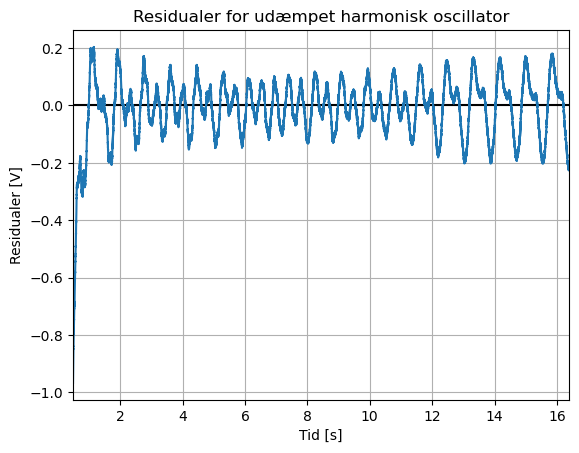

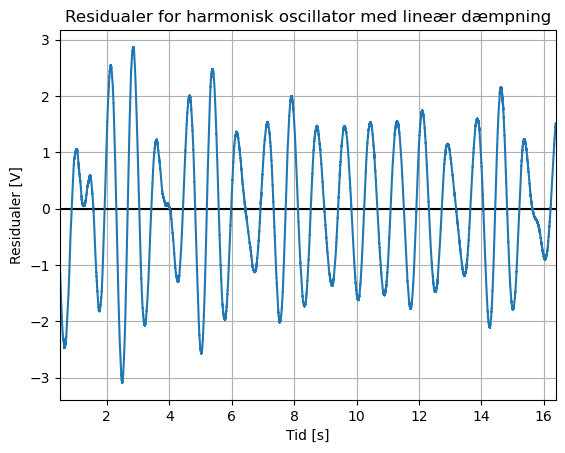

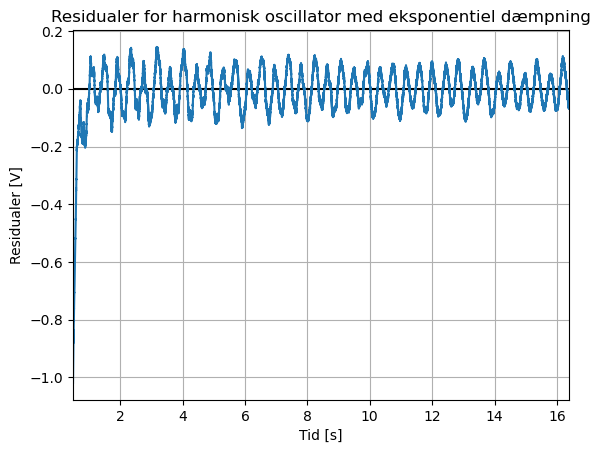

In [129]:
# Find residualer for modellen uden dæmpning

X = frimåling_t_arr
Y = [frimåling_v_arr[i] - ingen_dæmp_func(frimåling_t_arr[i], *ingen_dæmp_param) for i in range(len(frimåling_t_arr))]

plt.figure(2)
plt.grid()
plt.xlabel("Tid [s]")
plt.ylabel("Residualer [V]")
plt.title("Residualer for udæmpet harmonisk oscillator")

plt.axhline(y=0, color="black")

plt.plot(X, Y)
plt.gca().set_xlim([min(X), max(X)])
plt.show()

# Find residualer for modellem med lineær dæmpning

X = frimåling_t_arr
Y = [frimåling_v_arr[i] - lin_dæmp_func(frimåling_t_arr[i], *lin_dæmp_param) for i in range(len(frimåling_t_arr))]

plt.figure(3)
plt.grid()
plt.xlabel("Tid [s]")
plt.ylabel("Residualer [V]")
plt.title("Residualer for harmonisk oscillator med lineær dæmpning")

plt.axhline(y=0, color="black")

plt.plot(X, Y)
plt.gca().set_xlim([min(X), max(X)])
plt.show()

# Find residualer for modellen med eksponentiel dæmpning

X = frimåling_t_arr
Y = [frimåling_v_arr[i] - exp_dæmp_func(frimåling_t_arr[i], *exp_dæmp_param) for i in range(len(frimåling_t_arr))]

plt.figure(4)
plt.grid()
plt.xlabel("Tid [s]")
plt.ylabel("Residualer [V]")
plt.title("Residualer for harmonisk oscillator med eksponentiel dæmpning")

plt.axhline(y=0, color="black")

plt.plot(X, Y)
plt.gca().set_xlim([min(X), max(X)])
plt.show()


